# Pull Data from txt files created in the lab
- This example is using the 90 deg files 

In [1]:
# use this to see what is inside a folder 
import os 

# Set the folder path 
folder_to_view = 'AllDataFiles/Run3/90'
# print the contents 
index = 1
for filename in os.listdir(folder_to_view):
    if filename.endswith('.txt'):
        print(f"File #{index}: {filename}")
        index += 1

File #1: 10_5900B.txt
File #2: 11_6000B.txt
File #3: 1_5008B.txt
File #4: 2_5103B.txt
File #5: 3_5203B.txt
File #6: 4_5299B.txt
File #7: 5_5400B.txt
File #8: 6_5500B.txt
File #9: 7_5600B.txt
File #10: 8_5700B.txt
File #11: 9_5800B.txt


In [2]:
# This creates a new txt file with the data we need 
import os 
import itertools
import numpy as np 

# set the folder directory 
folder_to_view = 'AllDataFiles/Run3/90'

# this creates an empty list 
 x_and_y_values_from_all_files_dirRun3_90 = []

# This fills the list you created with the data from the files
for file in os.listdir(folder_to_view):
    # we are only interested in txt files 
    if file.endswith(".txt"): 
        # print(file)
        x90 =[]
        y90 = []

        with open(f'{folder_to_view}/{file}') as f: 
            for line in itertools.islice(f,4,None):
                line = line.split()
                x90.append(int(line[0]))
                y90.append(int(line[1]))

         x_and_y_values_from_all_files_dirRun3_90.append(x90)
         x_and_y_values_from_all_files_dirRun3_90.append(y90)

# this turns the list into an array so we can do vector math on it later 
 x_and_y_values_from_all_files_dirRun3_90 = np.array( x_and_y_values_from_all_files_dirRun3_90, dtype=int)
# This saves the array to a txt file for us to use later 
np.savetxt(" x_and_y_values_from_all_filesR3_90_Dic.txt",  x_and_y_values_from_all_files_dirRun3_90, delimiter =", ", fmt="%i")

# Pull data from the txt files we just created 

In [3]:
import numpy as np 

# Create an array to hold the data
# I called it x_and_y_values_from_all_files for clarity you can change it if you want
x_and_y_values_from_all_files = np.loadtxt(' x_and_y_values_from_all_filesR3_90_Dic.txt', dtype=int, delimiter=',')



# Let's print & see what we created
print('The type of variable we made is: ', type(x_and_y_values_from_all_files))
print(f"Number of files we found  = {len(x_and_y_values_from_all_files)/2}")
print(f"Total Number of arrays = {len(x_and_y_values_from_all_files)}")
print("\nThis should make sense each file gives an x and y array")
print("\nNow each file represents one data point aka one Delta E we need to calculate")
print(f"\t So we have {len(x_and_y_values_from_all_files)/2} data points to find the Bohr Magnetron")

The type of variable we made is:  <class 'numpy.ndarray'>
Number of files we found  = 11.0
Total Number of arrays = 22

This should make sense each file gives an x and y array

Now each file represents one data point aka one Delta E we need to calculate
	 So we have 11.0 data points to find the Bohr Magnetron


# Truncate the data to the 1st centroid order aka p=1 
- why: Because we don't need all the rings we only need one data point per file so let's only calculate $\Delta E$ from the main centroid

In [4]:
# Useful Functions 

def Plots(x, y, title, xlabel, ylabel, xrange = [ -1 , -1 ] , yrange = [ -1 , -1 ], figsize0 = 'a', figsize1 = 'a'):
    '''Plots anything but plots Intensities really well'''

    from astropy.visualization import astropy_mpl_style
    import matplotlib.pyplot as plt 

    plt.style.use(astropy_mpl_style)

    #style plot
    if figsize0 != 'a' and figsize1 != 'a': 
        print(f'Ratio set : ({figsize0}, {figsize1})')
        fig, axes = plt.subplots(figsize= (figsize0,figsize1))
        
    elif figsize0 == 'a' and figsize1 == 'a': 
        # print('Data ratio set')
        fig, axes = plt.subplots()
        if yrange == [ -1 , -1 ] :
            yspan = max(y) - min(y)
            yrange =[ min(y) - yspan/10. , max(y) + yspan/10. ]
            plt.ylim( yrange )
        if xrange == [ -1 , -1 ] :
            xspan = max(x) - min(x)
            xrange = [ min(x) - xspan/10. , max(x) + xspan/10. ]
            plt.xlim( xrange )

    #plot
    axes.plot(x, y, label= 'File Data', color='blue')

    #labels
    axes.set_title(title)
    axes.set_ylabel(ylabel)
    axes.set_xlabel(xlabel)
    return 

def MakeManyPlots( x_and_y_values_from_all_filesdictionary):
    '''Takes a dictionary of (x,y) arrays 
        Returns generic plots for each'''
    index = 1
    for i in range(0,len( x_and_y_values_from_all_filesdictionary),2): 
        Plots(
             x_and_y_values_from_all_filesdictionary[i],
             x_and_y_values_from_all_filesdictionary[i+1], 
            title =f'inital run: ({i},{i+1}), file #{index}',
            xlabel= 'Bins', 
            ylabel='Intensities [ADU]')
        index +=1
    return

def LabelPeaks_ShrinkData( xvalues, yvalues, lowerxlim, upperxlim, lowerylim): 
    ''' Takes: Original bulk data (x,y) and limits to truncate the data
        Returns: The desired peaks and the truncated data (xnew,ynew)'''
    from scipy.signal import find_peaks
    #Find bin x-values to associated local y-Max values
    peaks, _ = find_peaks(yvalues, distance=5)

    # width_full = peak_widths(xvalues, peaks, rel_height=1)
    # width_half = peak_widths(xvalues, peaks, rel_height=0.5)
    #Label the associated y-Max values
    all_ymax = yvalues[peaks]

    #forloop/zip: This applies the truncation on the Peak values ONlY
    #For p value our zip set (bin,intensity)
    #if: select the range of peaks we want
    #and: select the limit of intensity values
    tru_peaks = [p for (p,y) in zip(peaks,all_ymax) if ((p >= lowerxlim and p<= upperxlim) and y >= lowerylim)]

    # Truncate the data to make the peak values 
    new_yvalues =[]
    new_xvalues =[]
    for n in xvalues: 
        if n >= lowerxlim and n <= upperxlim:
            new_xvalues.append(n)
            new_yvalues.append(yvalues[n])
        else: 
            continue
    return tru_peaks, new_xvalues, new_yvalues

def PlotNewPeaks(newpeaks, OG_intensities ):
    '''Just a specific way to plot the Peaks with a red (x)'''
    import matplotlib.pyplot as plt
    plt.plot(newpeaks, OG_intensities[newpeaks], 'x', color ='red', label = 'Peaks')
    return

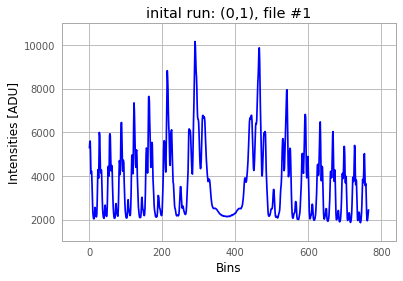

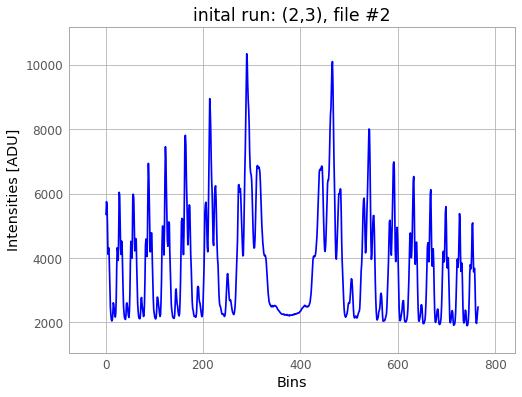

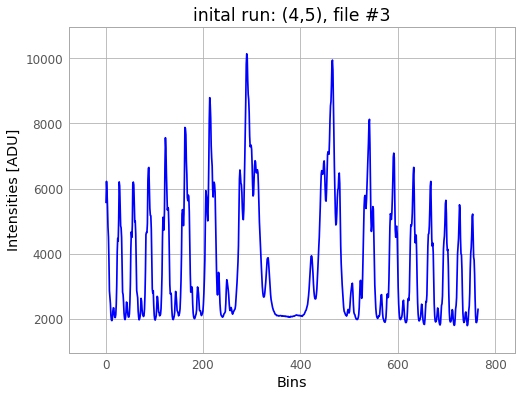

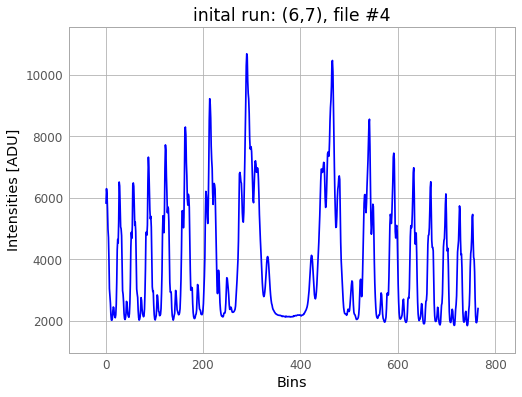

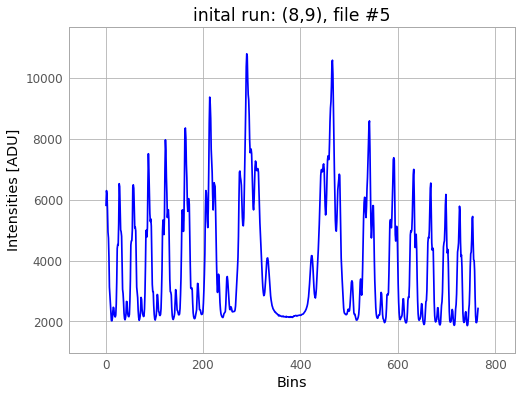

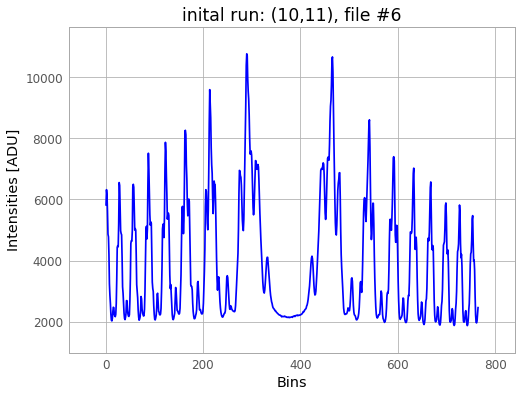

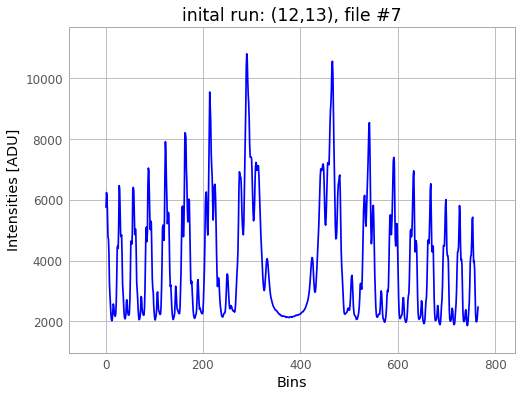

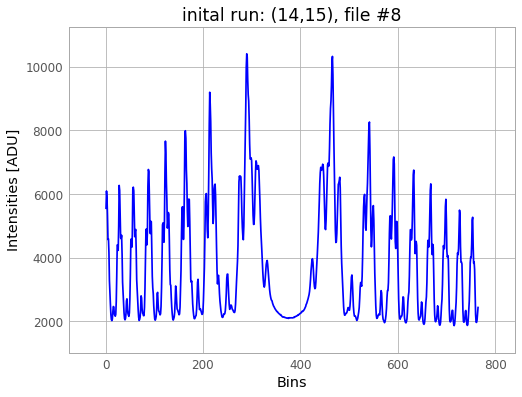

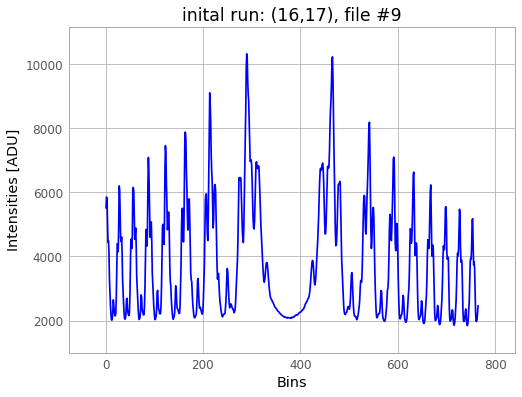

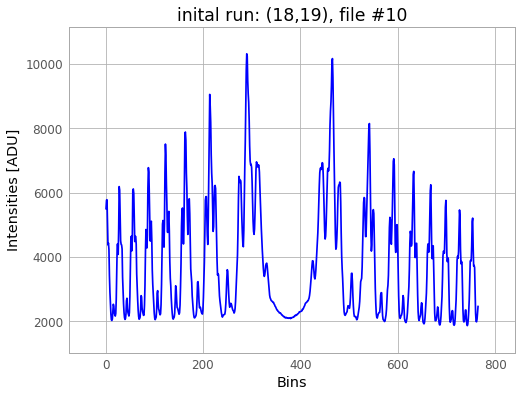

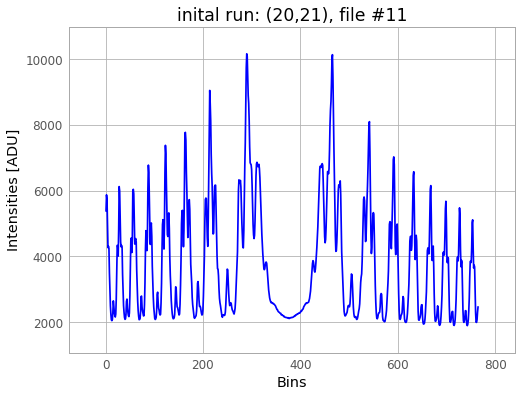

In [5]:
# Let's look at all the data in their plots 
MakeManyPlots(x_and_y_values_from_all_files)

## Based on our plots we see 
- we only need the pixels between 262-490
- with intensity above 4300 

 x20 and y20 are the new x & y arrays for file 11


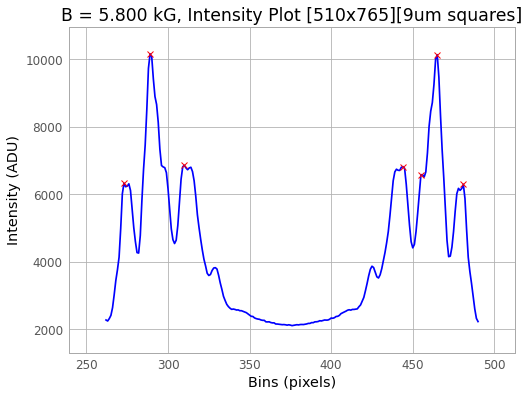

In [6]:
# Confirm this guess with a plot using the shrink data function 

# let's look at the last plot (20,21) aka File #11 in the folder 
peaks20, x20, y20 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[20],x_and_y_values_from_all_files[21],262,490,4300)

print(" x20 and y20 are the new x & y arrays for file 11")

# Change the Magnetic field to match the file 
Plots(x20,y20,
      'B = 5.800 kG, Intensity Plot [510x765][9um squares]', 
      'Bins (pixels)', 'Intensity (ADU)',
    )
PlotNewPeaks(peaks20,x_and_y_values_from_all_files[21])

## Great our pixel domain and our intensity range look good 
- now let's do this for all the files 

In [7]:
# 11 files = 11 peaks, 11 x arrays, 11 y arrays 
peaks1, x_1, y_1 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[0],x_and_y_values_from_all_files[1],262,490,4000)
peaks2, x_2, y_2 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[2],x_and_y_values_from_all_files[3],262,490,4300)
peaks3, x_3, y_3 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[4],x_and_y_values_from_all_files[5],262,490,4300)
peaks4, x_4, y_4 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[6],x_and_y_values_from_all_files[7],262,490,4300)
peaks5, x_5, y_5 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[8],x_and_y_values_from_all_files[9],262,490,4300)
peaks6, x_6, y_6 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[10],x_and_y_values_from_all_files[11],262,490,4300)
peaks7, x_7, y_7 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[12],x_and_y_values_from_all_files[13],262,490,4300)
peaks8, x_8, y_8 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[14],x_and_y_values_from_all_files[15],262,490,4300)
peaks9, x_9, y_9 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[16],x_and_y_values_from_all_files[17],262,490,4300)
peaks10, x_10, y_10 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[18],x_and_y_values_from_all_files[19],262,490,4300)
peaks11, x_11, y_11 = LabelPeaks_ShrinkData(x_and_y_values_from_all_files[20],x_and_y_values_from_all_files[21],262,490,4300)

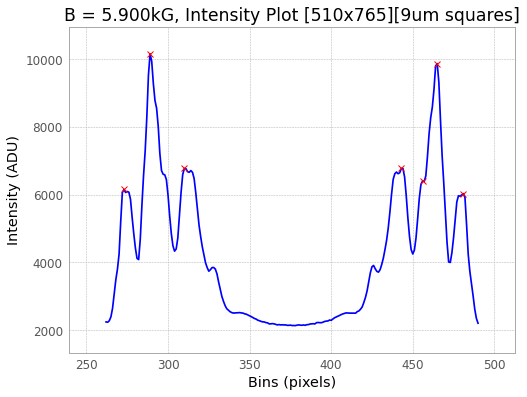

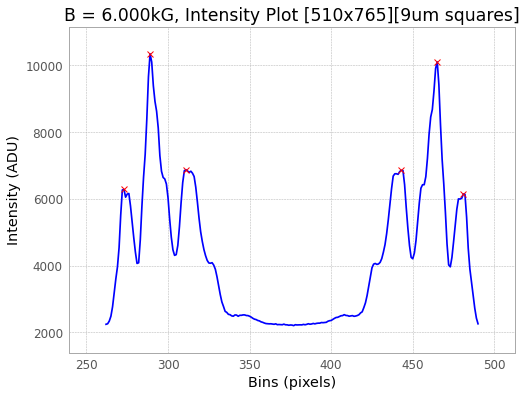

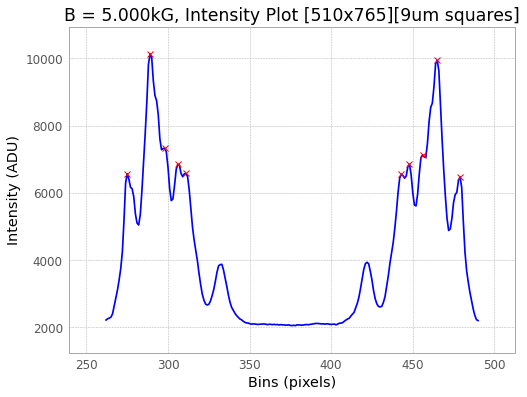

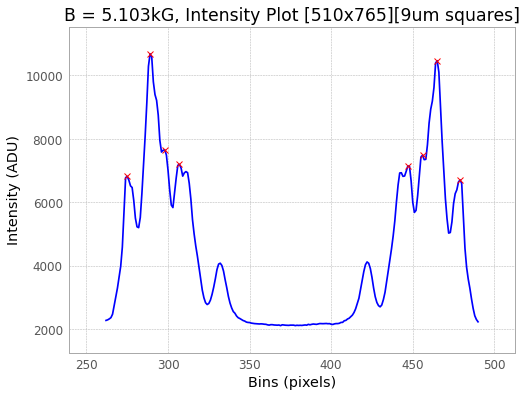

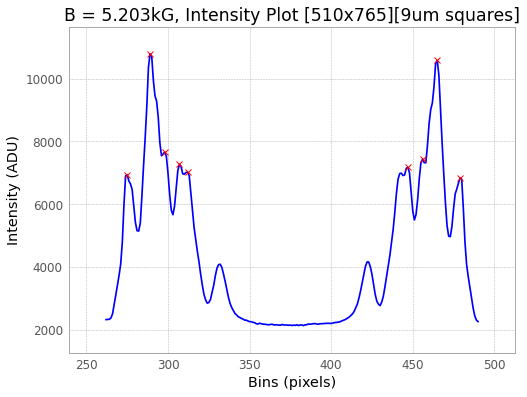

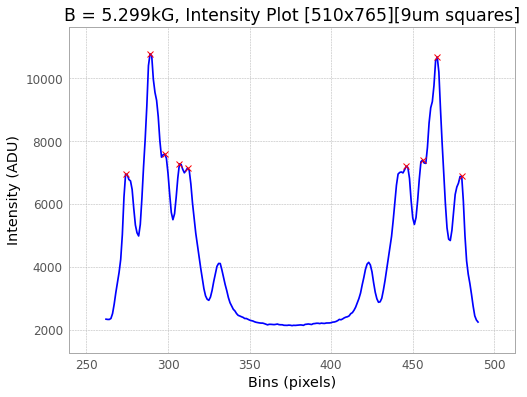

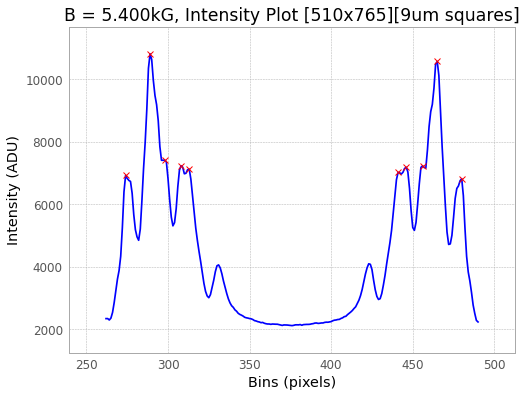

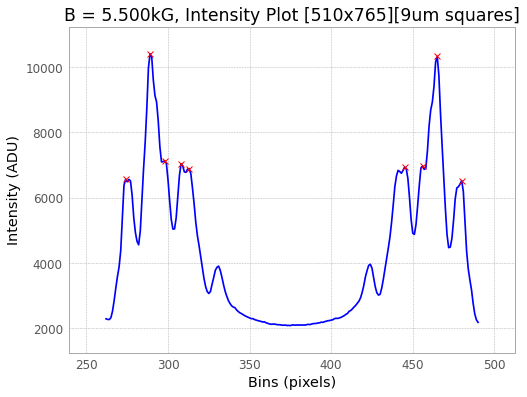

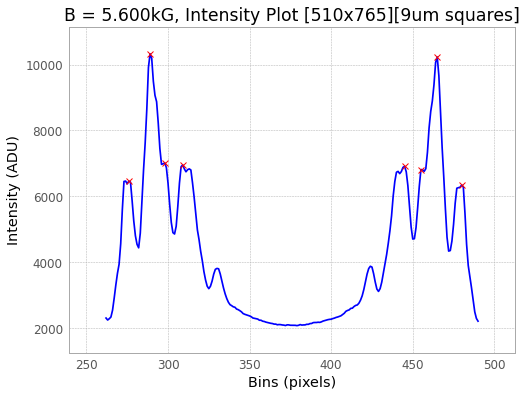

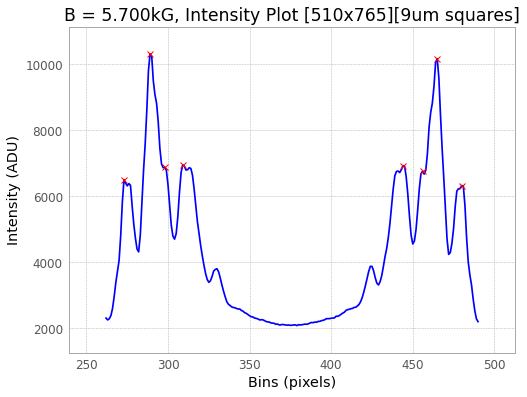

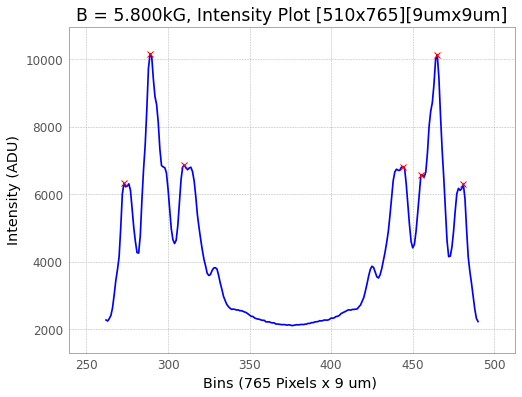

In [31]:

Plots(x_1,y_1, 
    'B = 5.900kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=8
    )
PlotNewPeaks(peaks1, x_and_y_values_from_all_files[1])


Plots(x_2,y_2, 
    'B = 6.000kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks2, x_and_y_values_from_all_files[3])

Plots(x_3,y_3, 
    'B = 5.000kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks3, x_and_y_values_from_all_files[5])


Plots(x_4,y_4, 
    'B = 5.103kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks4, x_and_y_values_from_all_files[7])


Plots(x_5,y_5, 
    'B = 5.203kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks5, x_and_y_values_from_all_files[9])

Plots(x_6,y_6, 
    'B = 5.299kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks6, x_and_y_values_from_all_files[11])

Plots(x_7,y_7, 
    'B = 5.400kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks7, x_and_y_values_from_all_files[13])

Plots(x_8,y_8, 
    'B = 5.500kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks8, x_and_y_values_from_all_files[15])

Plots(x_9,y_9, 
    'B = 5.600kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks9, x_and_y_values_from_all_files[17])

Plots(x_10,y_10, 
    'B = 5.700kG, Intensity Plot [510x765][9um squares]', 
    'Bins (pixels)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks10, x_and_y_values_from_all_files[19])

Plots(x_11,y_11, 
    'B = 5.800kG, Intensity Plot [510x765][9umx9um]', 
    'Bins (765 Pixels x 9 um) ', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
PlotNewPeaks(peaks11, x_and_y_values_from_all_files[21])


# Before we forget let's create an array for all of our magnetic field values

In [8]:
# This was copied from the 1st code block: 

# File #1: 10_5900B.txt
# File #2: 11_6000B.txt
# File #3: 1_5008B.txt
# File #4: 2_5103B.txt
# File #5: 3_5203B.txt
# File #6: 4_5299B.txt
# File #7: 5_5400B.txt
# File #8: 6_5500B.txt
# File #9: 7_5600B.txt
# File #10: 8_5700B.txt
# File #11: 9_5800B.txt

# Keep the order
# B_list_in_Gauss = [5900,5008,5103,5203,5299,5400,5500,5600,5700,5800]
B_list_in_Gauss = [5900,6000,5008,5103,5203,5299,5400,5500,5600,5700,5800]

# Convert to an arrray 
B_arr = np.array(B_list_in_Gauss)

# Some prints to double check 
print("We should have the same # of B's as we do files")
print(f"Files = {len(x_and_y_values_from_all_files)/2}, # of B's = {len(B_list_in_Gauss)}")

We should have the same # of B's as we do files
Files = 11.0, # of B's = 11


# Now we need to get our radius from our pixels 


In [9]:
# useful function 
def RadiusMeter(bin1,bin2):
    ''' Takes: final desired Bin-Peak locations (bin1, bin2)
        Returns: radius VALUE from the inner peak to the outer peak
                 in meters'''
    b1 = np.array(bin1)
    b2 = np.array(bin2)
   
    diameter = abs(b1 -b2)

    radius = diameter/2
    #reverse the order: inner ring is now first 
    # radius = radius[::-1]
    #convert to micrometer (per pixel) is (9um x 9um)
    radius_micometer = radius*9 #um
    radius_meter = radius_micometer*(10**(-6))

    return radius_meter

In [10]:
# For each file we can get our 2 radius values from the peaks list 
# why: because the peaks have the index value associated with our radius 
#      Note: in the 90 degree peaks we have 3 peaks but we only want 
#            the outer rings not the center one 
#      The 180 files have this: R1_1 = RadiusMeter(peaks1[0], peaks1[-1])
#                               R1_2 = RadiusMeter(peaks1[1], peaks1[-2])
#       because they only have 2 rings 

R1_1 =  RadiusMeter(peaks1[0], peaks1[-1]) # outermost ring
R1_2 =  RadiusMeter(peaks1[2], peaks1[-4]) # inner most ring

R2_1 =  RadiusMeter(peaks2[0], peaks2[-1])
R2_2 =  RadiusMeter(peaks2[2], peaks2[-4])

R3_1 =  RadiusMeter(peaks3[0], peaks3[-1])
R3_2 =  RadiusMeter(peaks3[3], peaks3[-4])

R4_1 =  RadiusMeter(peaks4[0], peaks4[-1])
R4_2 =  RadiusMeter(peaks4[3], peaks4[-4])

R5_1 =  RadiusMeter(peaks5[0], peaks5[-1])
R5_2 =  RadiusMeter(peaks5[3], peaks5[-4])

R6_1 =  RadiusMeter(peaks6[0], peaks6[-1])
R6_2 =  RadiusMeter(peaks6[3], peaks6[-4])

R7_1 =  RadiusMeter(peaks7[0], peaks7[-1])
R7_2 =  RadiusMeter(peaks7[3], peaks7[-4])

R8_1 =  RadiusMeter(peaks8[0], peaks8[-1])
R8_2 =  RadiusMeter(peaks8[3], peaks8[-4])

R9_1 =  RadiusMeter(peaks9[0], peaks9[-1])
R9_2 =  RadiusMeter(peaks9[3], peaks9[-4])

R10_1 =  RadiusMeter(peaks10[0], peaks10[-1])
R10_2 =  RadiusMeter(peaks10[3], peaks10[-4])

R11_1 =  RadiusMeter(peaks11[0], peaks11[-1])
R11_2 =  RadiusMeter(peaks11[2], peaks11[-4])


# put them all in a list to use later
radii = [
    R1_1, R1_2,
    R2_1, R2_2,
    R3_1, R3_2,
    R4_1, R4_2,
    R5_1, R5_2,
    R6_1, R6_2,
    R7_1, R7_2,
    R8_1, R8_2,
    R9_1, R9_2,
    R10_1, R10_2,
    R11_1, R11_2,
]

# Convert the radii into theta's 

In [11]:
# useful functions 
def ThetaRad(radius):
    '''Take radius and returns 1 Theta 
        focal length = 135E-3 m
        theta = r/f'''
    f =135E-3 #Focal length in meters 135mm
    theta = (radius/f)
    return theta

def ThetasRadArray(radii):
    '''Takes Array/list of radii Returns arr of thetas
        focal length = 135E-3 m
        theta = r/f'''
    import numpy as np
    rad = np.array(radii)
    thetas = ThetaRad(rad)
    return thetas

In [12]:
# Create a theta array by giving it the radii list we made
all_thetas = ThetasRadArray(radii)

# Now calculate $\Delta E$

In [13]:
# useful function 

def DeltaE(ThetaA, ThetaB):
    '''Takes 2 theta values and returns 1 Delta E
        Ebar = 3.638E-12 erg'''
    DeltaThetaPrime = ThetaA**2 - ThetaB**2
    Ebar = 3.638E-12 #erg
    constant = 2/Ebar
    
    deltaE = DeltaThetaPrime/constant

    return deltaE

def DeltaEPrime(thetasarray): 
    '''Takes an array from the peaks 
        2 thetas per set gives 1 Delta E's 
        Returns an arry of delta E's
        Ebar = 3.638E-12 erg '''
    import numpy as np
    if len(thetasarray) % 2 ==0:
        deltaEs = []
        for i in range( 0,len(thetasarray), 2):
            E1 = DeltaE(thetasarray[i],thetasarray[i+1])
            deltaEs.append(E1)

        deltaE = np.array(deltaEs)
    else: 
        print('This array does not have the correct dimension')
    
    return deltaE

In [14]:
# Create a delta E array by giving it all the thetas 
all_delE_values = DeltaEPrime(all_thetas)
print(all_delE_values)

[5.16899167e-17 8.74413511e-17 4.33568756e-17 4.44967822e-17
 4.44967822e-17 4.67179833e-17 4.72778311e-17 4.78336367e-17
 4.67280889e-17 4.97678400e-17 5.11502800e-17]


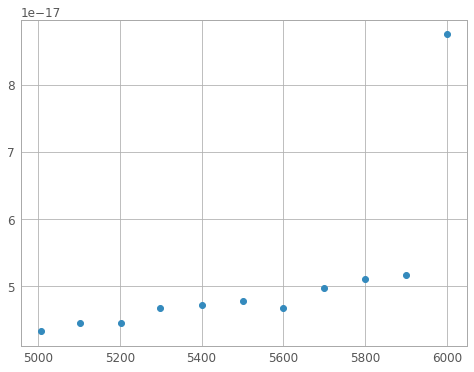

In [15]:
# Let's take a look at what we have before we move on 
import matplotlib.pyplot as plt

plt.scatter(B_list_in_Gauss,all_delE_values)

-  There is an outlier - it's up to you what you want to do about that value 

# Let's start our best fit function 

In [16]:
# Delta E function 
def E(B,mu, c): # x,unknown,unknown
    # assume we know A 
    A = 1
    return A*mu*B + c

In [17]:
# using scipy 
from scipy.optimize import curve_fit

# give the system some initial guesses 
p02 = [9.3E-21, 0E-21]

print('\nA = 1 Known, fit mu_0 : 9.2741E-21\n')
popt, pcov = curve_fit( 
                    E,
                    B_arr,
                    all_delE_values,
                    p0= p02, 
                    absolute_sigma=True,
                    )

for i in range(0,len(popt)):
    print('param ',i,' = ',popt[i], '+/-', np.sqrt(pcov[i,i]))


A = 1 Known, fit mu_0 : 9.2741E-21

param  0  =  2.5154387542669968e-20 +/- 0.0009585883603707967
param  1  =  -8.738273505380091e-17 +/- 5.281981465680134


# Make a pretty plot 

In [23]:
# useful function
def SaveFigure(filename):
    '''If you forget the keyword'''
    import matplotlib.pyplot as plt 
    plt.savefig(filename, bbox_inches ='tight' )
    return

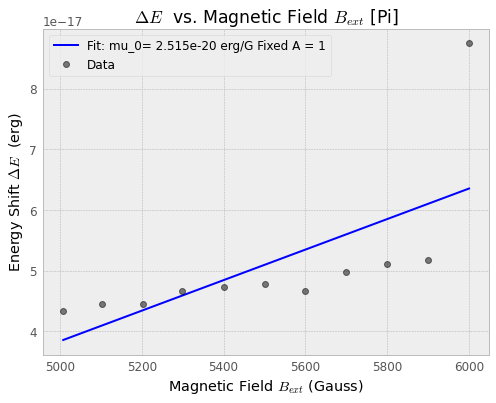

In [28]:
# PLOT
import matplotlib.pyplot as plt 
#style
plt.figure()
plt.style.use('bmh')


# Better looking line for the fit 
B_line = np.linspace(min(B_arr), max(B_arr), 1000)
fit = E(B_line, *popt)

# Plot the fitted line 
plt.plot(B_line, 
        fit, 
        label = 'Fit: mu_0= %1.3e erg/G Fixed A = 1' % popt[0], 
        color = 'b')

# plot your original data 
plt.errorbar(
    B_arr, 
    all_delE_values, 
    # yerr= sigmaE,
    # xerr= Berr, 
    fmt='o', 
    label = 'Data', 
    color='black',
    alpha =0.5
    )

#labels
plt.title("$\\Delta E$  vs. Magnetic Field $B_{ext}$ [Pi]")
plt.xlabel('Magnetic Field $B_{ext}$ (Gauss)')
plt.ylabel("Energy Shift $\\Delta E$  (erg)")
plt.legend(loc=2)

# print(popt2)

SaveFigure("Graphs/PiFitDelEvsB.png")

# Statistics 

In [30]:
# useful functions 

# Chi^2 Values 
def Chi2Values(fitfunction, xdata, ydata, fitparams, ysigma):
    
    import scipy.stats as stat

    yfit = fitfunction(xdata, *fitparams)

    chisq = sum( (ydata - yfit)**2 / ysigma**2 )

    ndf = len(ydata)-len(fitparams)

    chisq_reduced = chisq/float(ndf)

    cdf = stat.chi2.cdf(chisq, df = ndf)

    pvalue = 1-cdf

    print('Chi-square: ',chisq)
    print('Degrees of freedom: ',ndf)
    print('Reduced chi-square: ',chisq_reduced)
    print('CDF: ', cdf)
    print('p-test value (1 Tail bc not symmetric): ',pvalue)

    return

In [ ]:
print('Fit: mu_0, A = 1')
Chi2Values(E,B_arr,all_delE_values,popt,sigmaE) # not significant 